In [829]:
library("ImpulseDE2")
library('dplyr')
library(ggplot2)

In [830]:
pathSave='/home/khrovatin/timeTrajectoriesNet/data/stages/DE_across_stages/'

In [831]:
genes<-read.table('/home/khrovatin/timeTrajectoriesNet/data/counts/mergedGenes_counts.tsv', header=TRUE,row.names=1, sep="\t")
conditions<-read.table('/home/khrovatin/timeTrajectoriesNet/data/RPKUM/conditions_mergedGenes.tsv', header=TRUE,row.names='Measurment', sep="\t")
#R imported colnames of genes with changes but gene IDs remained ok
rownames(conditions)<-make.names(rownames(conditions))

In [833]:
PHENOTYPES_ORDERED=c('no_agg','disappear', 'stream', 'lag', 'tag', 'tip', 'slug', 'mhat', 'cul', 'FB', 'tag_spore')
PHENOTYPES_X=data.frame(Phenotype=PHENOTYPES_ORDERED,X=c(1:length(PHENOTYPES_ORDERED)))

In [834]:
conditions_annotated=conditions[rowSums(conditions[, PHENOTYPES_ORDERED])>0, ]
X=data.frame(row.names=rownames(genes))
Y=data.frame()
for (row_idx in 1:dim(conditions_annotated)[1]){
  y=conditions_annotated[row_idx,]
  x=genes[,rownames(y)]
  repeated_sample=0
  for (phenotype in PHENOTYPES_ORDERED){
    if (y[phenotype]==1){
      sample_name=paste(rownames(y),repeated_sample,sep='_')
      X[,sample_name]=x
      Y[sample_name,c('Sample','Condition','Batch','Time')]=c(sample_name,'case',y['Replicate'],PHENOTYPES_X[PHENOTYPES_X['Phenotype']==phenotype,'X'])
      repeated_sample=repeated_sample+1
    }
  }
}
Y<-Y[order(Y$Time),]

In [ ]:
objectImpulseDE2 <- runImpulseDE2(matCountData = as.matrix(X), dfAnnotation = Y,boolCaseCtrl = FALSE,vecConfounders = c("Batch"),scaNProc = 20)

ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5,6,7,8,9,10,11
Case: Found the samples at time point 1: FDpool01_TCGCAGG_Hr00_mappedGene_expressions_All_milestone_mRNA_gff_0,FDpool02_TCGCAGG_Hr00_mappedGene_expressions_All_milestone_mRNA_gff_0,Ax4_r1_00h_9_S86_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,Ax4_r1_04h_10_S87_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,Ax4_r2_00h_9_S58_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,Ax4_r2_04h_10_S59_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,Pool26_AX4_bio2_hr00_1_TCGCAGG_mappedGene_expressions_All_milestone_mRNA_gff_0,Pool26_AX4_bio2_hr06_7_CTCGATG_mappedGene_expressions_All_milestone_mRNA_gff_0,pool27_AX4_bio1_hr00_1_TCGCAGG_mappedGene_expressions_All_milestone_mRNA_gff_0,pool27_AX4_bio1_hr06_7_CTCGATG_mappedGene_expressions_All_milestone_mRNA_gff_0,Pool28_AX4_bio2_hr00_1_13_ACTATCA_mappedGene_expressions_All_milestone_mRNA_gff_0,pool30_MybBGF

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates



In [54]:
saveRDS(object=objectImpulseDE2,file=paste(pathSave,'DEacrossStages.rds',sep=''))
saveRDS(object=PHENOTYPES_X,file=paste(pathSave,'DEacrossStages_phenotypesOrder.rds',sep=''))

In [12]:
fdr=0.05
result<-objectImpulseDE2$dfImpulseDE2Results
result<-result[result$padj<=fdr & ! is.na(result$padj),]
result<-result[order(result$padj),]
write.table(result,file=paste(pathSave,'DEacrossStages_padj',fdr,'.tsv',sep='') ,sep='\t',row.names = FALSE)

## Individual strains

In [14]:
unique(conditions$Strain)[4:length(unique(conditions$Strain))]

[1] gtaI       cudA       dgcA       gtaG       tagB       comH      
 [7] gbfA       tgrC1      tgrB1      tgrB1C1    gtaC       mybB      
[13] amiB       acaA       acaAPkaCoe ac3PkaCoe  PkaCoe     pkaR      
21 Levels: ac3PkaCoe acaA acaAPkaCoe amiB AX4 comH cudA dgcA ecmARm ... tgrC1

In [19]:
for (strain in unique(conditions$Strain)){
  conditions_annotated=conditions[rowSums(conditions[, PHENOTYPES_ORDERED])>0 &conditions$Strain==strain, ]
  #Drop phenotypes not annoated in this strain
  phenotypes_count<-colSums(conditions_annotated[, PHENOTYPES_ORDERED])
  phenotypes_present<-names(phenotypes_count[phenotypes_count>0])
  if (length(phenotypes_present)>1){
      phenotypes_x=data.frame(Phenotype=phenotypes_present,X=c(1:length(phenotypes_present)))
      drop<-names(phenotypes_count[phenotypes_count==0])
      drop<-which(colnames(conditions_annotated) %in% drop)
      conditions_annotated=conditions_annotated[,-drop]
      X=data.frame(row.names=rownames(genes))
      Y=data.frame()
      for (row_idx in 1:dim(conditions_annotated)[1]){
        y=conditions_annotated[row_idx,]
        x=genes[,rownames(y)]
        repeated_sample=0
        for (phenotype in phenotypes_present){
          if (y[phenotype]==1){
            sample_name=paste(rownames(y),repeated_sample,sep='_')
            X[,sample_name]=x
            Y[sample_name,c('Sample','Condition','Batch','Time')]=c(sample_name,'case',y['Replicate'],phenotypes_x[phenotypes_x['Phenotype']==phenotype,'X'])
            repeated_sample=repeated_sample+1
          }
        }
      } 

      Y<-Y[order(Y$Time),]
      print(strain)
      print(dim(conditions_annotated))
      print(paste(dim(X)[1],dim(X)[2],sum(conditions_annotated[,phenotypes_present])))
      objectImpulseDE2 <- runImpulseDE2(matCountData = as.matrix(X), dfAnnotation = Y,boolCaseCtrl = FALSE,vecConfounders = c("Batch"),
                                        boolIdentifyTransients = TRUE,scaNProc = 20 )
      saveRDS(object=objectImpulseDE2,file=paste(pathSave,'strain/',strain,'_DEacrossStages.rds',sep=''))
      write.table(phenotypes_x,file=paste(pathSave,'strain/',strain,'_DEacrossStages_phenotypesOrder.tsv',sep=''),sep='\t',row.names = FALSE)
    }
}
    

[1] "cudA"
[1] 18 11
[1] "12828 24 24"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5,6
Case: Found the samples at time point 1: cudA2_6_r2_0h_7_S173_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,cudA2_6_r2_4h_8_S174_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,cudA2_6_r3_0h_16_S182_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,cudA2_6_r3_4h_17_S183_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 2: cudA2_6_r2_8h_9_S175_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,cudA2_6_r2_12h_10_S176_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,cudA2_6_r3_8h_18_S184_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,cudA2_6_r3_12h_19_S185_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 3: cudA2_6_r2_12h_10_S176_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_1,cudA2_6_r3_12h_19_S185_L003_R1_001_mappedGene_express

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 13 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.11 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 5.24 min.

# Fitting sigmoid model to case condition

Consumed time: 1.75 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 7.14 min.



[1] "dgcA"
[1] 18 11
[1] "12828 21 21"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5,6
Case: Found the samples at time point 1: dgcA_0h_r1_1_S52_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,dgcA_4h_r1_2_S53_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,dgcA_8h_r1_3_S54_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,dgcA_0h_r2_10_S61_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,dgcA_4h_r2_11_S62_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 2: dgcA_8h_r1_3_S54_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_1,dgcA_8h_r2_12_S63_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 3: dgcA_8h_r2_12_S63_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_1
Case: Found the samples at time point 4: dgcA_12h_r1_4_S55_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,dgcA_14h_r1_5_S56_L003_R1_001_mappedGene_expressions

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 10 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.11 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 5.41 min.

# Fitting sigmoid model to case condition

Consumed time: 1.86 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 7.42 min.



[1] "gtaG"
[1] 14 12
[1] "12828 22 22"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5,6,7
Case: Found the samples at time point 1: gtaG_r1_00hr_1_S79_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gtaG_r1_04hr_2_S80_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gtaG_r2_00h_8_S57_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gtaG_r2_04h_24_S72_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 2: gtaG_r1_08hr_8_S85_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gtaG_r2_04h_24_S72_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_1,gtaG_r2_08h_25_S73_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 3: gtaG_r1_08hr_8_S85_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_1,gtaG_r1_12hr_4_S81_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gtaG_r2_08h_25_S73_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_1


# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 8 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.11 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 5.56 min.

# Fitting sigmoid model to case condition

Consumed time: 1.67 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 7.38 min.



[1] "tagB"
[1] 13 10
[1] "12828 21 21"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5
Case: Found the samples at time point 1: pool36_tagB__bio1_00h_1_TCGCAGG_mappedGene_expressions_All_milestone_mRNA_gff_0,tagB_bio2_00h_14_S149_L008_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 2: pool36_tagB__bio1_08h_8_GCTCGAA_mappedGene_expressions_All_milestone_mRNA_gff_0,pool36_tagB__bio1_12h_9_ACCAACT_mappedGene_expressions_All_milestone_mRNA_gff_0,tagB_bio2_06h_20_S155_L008_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tagB_bio2_08h_21_S156_L008_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tagB_bio2_12h_22_S157_L008_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tagB_bio2_16h_23_S158_L008_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 3: pool36_tagB__bio1_08h_8_GCTCGAA_mappedGene_expressions_All_milestone_mRNA_gff_1,pool36_tagB__bio1_12h_9_ACCAACT_mappedGene_expressions_All_mile

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

Consumed time: 0.11 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 4.98 min.

# Fitting sigmoid model to case condition

Consumed time: 1.96 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 7.09 min.



[1] "comH"
[1] 20 10
[1] "12828 32 32"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5
Case: Found the samples at time point 1: t345_r1_00h_38_S111_L001_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,t345_r1_02h_39_S112_L001_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,t345_r1_04h_40_S113_L001_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,t345_r1_06h_41_S114_L001_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,t345_r2_00h_33_S153_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,t345_r2_02h_34_S154_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,t345_r2_04h_35_S155_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,t345_r2_06h_36_S156_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 2: t345_r1_08h_42_S115_L001_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,t345_r2_08h_37_S157_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,t345_r2_12h_38_S158_L002_R1_001_ma

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 1 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.12 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 4.28 min.

# Fitting sigmoid model to case condition

Consumed time: 1.92 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 6.37 min.



[1] "gbfA"
[1] 20  9
[1] "12828 28 28"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4
Case: Found the samples at time point 1: gbfA_0h_r1_28_S79_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gbfA_4h_r1_29_S80_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gbfA_6h_r1_30_S81_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gbfA_8h_r1_31_S82_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gbfA_24h_r1_37_S88_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gbfA_r3_00h_1_S126_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gbfA_r3_04h_2_S127_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gbfA_r3_06h_3_S128_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gbfA_r3_08h_4_S129_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gbfA_r3_10h_5_S130_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gbfA_r3_12h_6_S131_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,gbfA_r3_14h_

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 4 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.11 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 3.49 min.

# Fitting sigmoid model to case condition

Consumed time: 1.79 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 5.43 min.



[1] "tgrC1"
[1] 20 10
[1] "12828 30 30"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5
Case: Found the samples at time point 1: tgrC1_r1_00h_21_S37_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrC1_r1_04h_22_S38_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrC1_r1_06h_23_S39_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrC1_r1_12h_26_S42_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrC1_r1_20h_29_S45_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrC1_r1_24h_30_S46_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrC1_r2_00h_11_S27_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrC1_r2_04h_12_S28_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrC1_r2_06h_13_S29_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrC1_r2_24h_20_S36_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 2: tgrC1_r1_10h_25_S41_L003_R1_001_ma

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 8 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.12 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 4.77 min.

# Fitting sigmoid model to case condition

Consumed time: 1.91 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 6.85 min.



[1] "tgrB1"
[1] 20 12
[1] "12828 36 36"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5,6,7
Case: Found the samples at time point 1: tgrB1_r1_00h_11_S27_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1_r1_04h_12_S28_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1_r1_06h_13_S29_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1_r1_08h_14_S30_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1_r1_24h_20_S36_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1_r2_00h_21_S37_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1_r2_04h_22_S38_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1_r2_06h_23_S39_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1_r2_24h_30_S46_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 2: tgrB1_r1_16h_18_S34_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1_r1_20h_19_S35_L003_R1_00

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 14 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.19 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 6.02 min.

# Fitting sigmoid model to case condition

Consumed time: 1.98 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 8.23 min.



[1] "tgrB1C1"
[1] 20 12
[1] "12828 35 35"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5,6,7
Case: Found the samples at time point 1: tgrB1C1_r1_00h_1_S17_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1C1_r1_04h_2_S18_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1C1_r1_24h_10_S26_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1C1_r2_00h_1_S17_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1C1_r2_04h_2_S18_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1C1_r2_06h_3_S19_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1C1_r2_24h_10_S26_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 2: tgrB1C1_r1_12h_6_S22_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1C1_r2_14h_7_S23_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1C1_r2_16h_8_S24_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,tgrB1C1_r2_20h_9_S

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 3 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.15 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 5.85 min.

# Fitting sigmoid model to case condition

Consumed time: 1.89 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 7.93 min.



[1] "acaAPkaCoe"
[1] 16 13
[1] "12828 50 50"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5,6,7,8
Case: Found the samples at time point 1: pool36_acaAKO_pkaC3_bio1_00h_14_TTGGATC_mappedGene_expressions_All_milestone_mRNA_gff_0,pool36_acaAKO_pkaC3_bio1_06h_20_CATGCTC_mappedGene_expressions_All_milestone_mRNA_gff_0,pool36_acaAKO_pkaC3_bio1_08h_21_ACGCAAC_mappedGene_expressions_All_milestone_mRNA_gff_0,pool36_acaAKO_pkaC3_bio1_12h_22_GCATTGG_mappedGene_expressions_All_milestone_mRNA_gff_0,pool36_acaAKO_pkaC3_bio1_20h_24_CAATATG_mappedGene_expressions_All_milestone_mRNA_gff_0,pool36_acaAKO_pkaC3_bio1_24h_25_TGACGTC_mappedGene_expressions_All_milestone_mRNA_gff_0,pool37_acaA_pkaC1_bio1_00h_14_TTGGATC_mappedGene_expressions_All_milestone_mRNA_gff_0,pool37_acaA_pkaC1_bio1_06h_20_CATGCTC_mappedGene_expressions_All_milestone_mRNA_gff_0,pool37_acaA_pkaC1_bio1_08h_21_ACGCAAC_mappedGene_expressions_All_milestone_mRNA_gff_0,pool37_acaA_pkaC1_bio1_12h_22_GCATTGG_mappedGene_expressions_All_milestone_mRNA_gff

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 1 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.17 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 5.62 min.

# Fitting sigmoid model to case condition

Consumed time: 1.52 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 7.36 min.



[1] "PkaCoe"
[1] 17 13
[1] "12828 28 28"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5,6,7,8
Case: Found the samples at time point 1: PkaCoe25_r2_00h_21_S97_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,PkaCoe25_r2_04h_22_S98_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,PkaC25_r3_00h_31_S47_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,PkaC25_r3_04h_32_S48_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 2: PkaCoe25_r2_04h_22_S98_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_1,PkaCoe25_r2_08h_23_S99_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0,PkaC25_r3_08h_33_S49_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 3: PkaCoe25_r2_08h_23_S99_L002_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_1
Case: Found the samples at time point 4: PkaC25_r3_12h_34_S50_L003_R1_001_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: F

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



[1] "Corrected 6 DESEq2 dispersion estimates which to avoid variance overestimation and loss of discriminatory power for model selection."


Consumed time: 0.13 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 5.6 min.

# Fitting sigmoid model to case condition

Consumed time: 1.72 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 7.5 min.



[1] "pkaR"
[1] 13 10
[1] "12828 15 15"


ImpulseDE2 for count data, v1.10.0

# Process input



Processing Details:
ImpulseDE2 runs in case-only mode.
Found time points: 1,2,3,4,5
Case: Found the samples at time point 1: pool35_pkaR_00h_bio1_9_ACCAACT_mate1_mappedGene_expressions_All_milestone_mRNA_gff_0,pool38_pkaR__00h_bio2_22_GCATTGG_mate1_mappedGene_expressions_All_milestone_mRNA_gff_0,pool38_pkaR__06h_bio2_28_AGATAGG_mate1_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 2: pool35_pkaR_08h_bio1_16_TAATGCG_mate1_mappedGene_expressions_All_milestone_mRNA_gff_0,pool38_pkaR__08h_bio2_29_CCGATTG_mate1_mappedGene_expressions_All_milestone_mRNA_gff_0
Case: Found the samples at time point 3: pool35_pkaR_08h_bio1_16_TAATGCG_mate1_mappedGene_expressions_All_milestone_mRNA_gff_1,pool38_pkaR__08h_bio2_29_CCGATTG_mate1_mappedGene_expressions_All_milestone_mRNA_gff_1
Case: Found the samples at time point 4: pool35_pkaR_12h_bio1_4_GGATCAA_mate1_mappedGene_expressions_All_milestone_mRNA_gff_0,pool35_pkaR_16h_bio1_5_GCAAGAT_mate1_mappedGene_expressions_Al

# Run DESeq2: Using dispersion factorscomputed by DESeq2.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

Consumed time: 0.1 min.

# Compute size factors

# Fitting null and alternative model to the genes

Consumed time: 4.02 min.

# Fitting sigmoid model to case condition

Consumed time: 1.58 min.

# Differentially expression analysis based on model fits

Finished running ImpulseDE2.

TOTAL consumed time: 5.74 min.



In [237]:
fdr=0.05
result<-objectImpulseDE2$dfImpulseDE2Results
result<-result[result$padj<=fdr & ! is.na(result$padj),]
result<-result[order(result$padj),]

In [756]:
result<-result[order(result$padj),]

In [757]:
top<-rownames(result[result$isMonotonous,])[1:20]


In [303]:
nrow(result)

[1] 6910

In [276]:
length(rownames(result))

[1] 7428

In [189]:
library(ggplot2)

In [827]:
gene_ids=c('DDB_G0286109')
lsgplotsGenes <- plotGenes(
vecGeneIDs = gene_ids,
scaNTopIDs = NULL,
objectImpulseDE2 = objectImpulseDE2,
boolCaseCtrl = FALSE,
dirOut = NULL,
strFileName = NULL,
vecRefPval = NULL,
strNameRefMethod = NULL)

[1] "DDB_G0286109"
                     Gene            p         padj loglik_full loglik_red
DDB_G0286109 DDB_G0286109 0.0001090675 0.0002597453   -84.72661   -97.5017
             df_full df_red     mean converge_impulse converge_const
DDB_G0286109       8      3 79.81552                0              0
             converge_sigmoid impulseTOsigmoid_p impulseTOsigmoid_padj
DDB_G0286109                0          0.4566795                     1
             sigmoidTOconst_p sigmoidTOconst_padj isTransient isMonotonous
DDB_G0286109     2.518952e-05        6.242421e-05       FALSE         TRUE
             allZero
DDB_G0286109   FALSE
       beta          h0          h1          h2          t1          t2 
  2.8580175  13.4292527  70.9793577 115.0843163   0.5724748   6.1451929 
       beta          h0          h1           t 
  0.5304269  59.5319919 190.6692479   8.1976430 


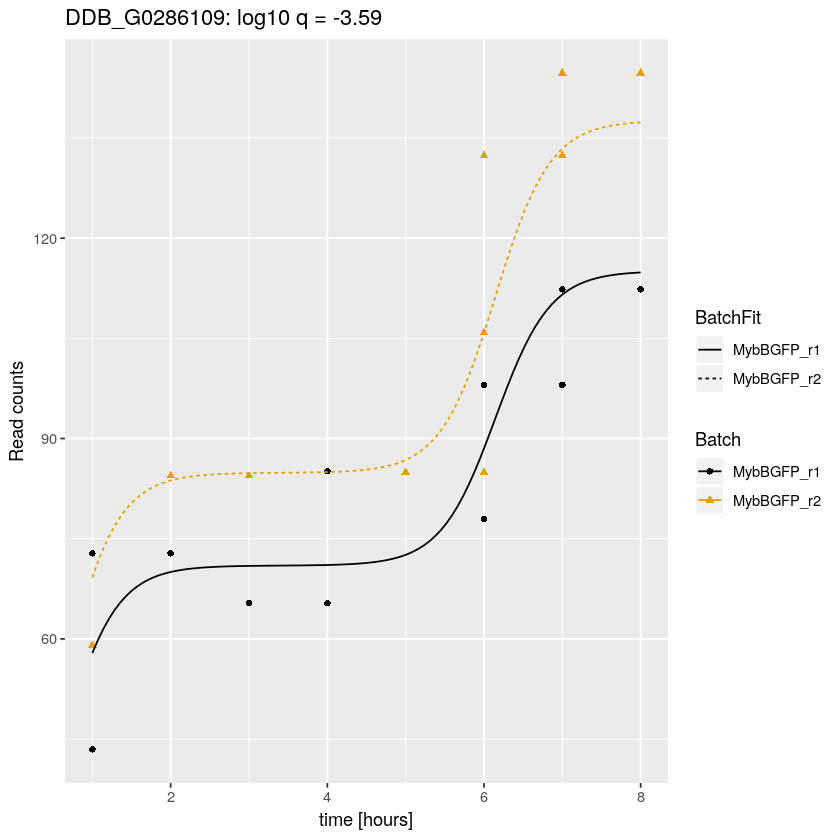

In [828]:
i=1
print(lsgplotsGenes[[i]])
print(gene_ids[i])
print(objectImpulseDE2$dfImpulseDE2Results[gene_ids[i],])

print(objectImpulseDE2@lsModelFits$case[gene_ids[i]][[1]]$lsImpulseFit$vecImpulseParam)
print(objectImpulseDE2@lsModelFits$case[gene_ids[i]][[1]]$lsSigmoidFit$vecSigmoidParam)

## Parse the result - find stages where gene is up(down)regulated

In [826]:
objectImpulseDE2<-readRDS(paste(pathSave,'strain/','MybBGFP','_DEacrossStages.rds',sep=''))


In [822]:
for (strain in unique(conditions$Strain)){
if (file.exists(paste(pathSave,'strain/',strain,'_DEacrossStages.rds',sep=''))){

objectImpulseDE2<-readRDS(paste(pathSave,'strain/',strain,'_DEacrossStages.rds',sep=''))
phenotypes_x<-read.table(paste(pathSave,'strain/',strain,'_DEacrossStages_phenotypesOrder.tsv',sep=''),header=TRUE)
min_x<-min(phenotypes_x$X)
max_x<-max(phenotypes_x$X)

#Default is 0.001, but they used 0.01 in the paper, but 0.001 seems to neglect many probably DE genes
objectImpulseDE2<-updateDEAnalysis(objectImpulseDE2,scaQThresTransients=0.01)

model<-objectImpulseDE2@lsModelFits$case
result<-objectImpulseDE2$dfImpulseDE2Results
result<-result[! is.na(result$padj),]
result<-result[result$isMonotonous |result$isTransient,]
if (nrow(result[result$isMonotonous & result$isTransient,])>0) stop('Asigned both transient and monotonous')
annotation<-objectImpulseDE2@dfAnnotationProc
print(paste(strain,nrow(result)))

parsed<-data.frame()

for(gene in rownames(result)){
    parsed[gene,c('impulse_padj','impulseTOsigmoid_padj','sigmoid_padj')]=result[gene,
                                c('padj','impulseTOsigmoid_padj','sigmoidTOconst_padj')]
    type=''
    # Was gene assigned to be transient or monotonous
    if (result[gene,'isTransient']) type='transient'
    if (result[gene,'isMonotonous']) type='monotonous'
    parsed[gene,'Type']=type
    
    if (type=='monotonous'){
        
        # If monotonous it can be sigmoid or impulse monotonous - if only sigmoid was used the split could be 
        # wrong (in the middle of relatively stable stage) - thus use as threshold the t from impulse 
        # that is closest to the sigmoid t
        if(result[gene,'padj']>result[gene,'sigmoidTOconst_padj']){
            model_data=as.list(model[gene][[1]]$lsSigmoidFit$vecSigmoidParam)
            t=model_data$t
        }else{
            model_data=as.list(model[gene][[1]]$lsSigmoidFit$vecSigmoidParam)
            model_impulse=as.list(model[gene][[1]]$lsImpulseFit$vecImpulseParam)
            diff_t1=abs(model_data$t-model_impulse$t1)
            diff_t2=abs(model_data$t-model_impulse$t2)
            if(diff_t1<diff_t2){t=model_impulse$t1
            } else {t=model_impulse$t2}
        }
        
        # If t in between stages assign impulse, else (t larger/smaller than last/first stage) assume 
        # that only the last/first stage is DE - assign impulse_manual as this is not directly based on the model
        assignment=NA
        if (min_x<t & t<max_x){
            assignment='impulse'
        #Assumes that stages/times are integers
        } else if (min_x>=t ){
            t=min_x+0.1
            assignment='impulse_manual_border'
        } else if (max_x <= t ){
            t=max_x-0.1
            assignment='impulse_manual_border'
        }
        parsed[gene,'Assignment']=assignment
        
        # Does gene change up or down through time and which stages are on each side of the tipping point
        phenotypes1=as.vector(phenotypes_x[phenotypes_x$X<t,'Phenotype'])
        phenotypes2=as.vector(phenotypes_x[phenotypes_x$X>t,'Phenotype'])
        if (model_data$h1>model_data$h0) {
            parsed[gene,'Direction']='up'
            parsed[gene,phenotypes1]='down'
            parsed[gene,phenotypes2]='up'
        }else{
            parsed[gene,'Direction']='down'
            parsed[gene,phenotypes1]='up'
            parsed[gene,phenotypes2]='down'
        }
        
    } else if (type=='transient') {
        model_data=as.list(model[gene][[1]]$lsImpulseFit$vecImpulseParam)
        t1=model_data$t1
        t2=model_data$t2
        proceed=TRUE
        # t1,t2 can be between different stages - assign phenotypes to up/down based on t1,t2 and 
        # assignments is based directly on the models ('impulse'). If t1/t2 is larger or smaller 
        # than first/last stage assume that only last/first stage is in this state (assignment is impulse_manual)
        # If t1,t2 are between the same two stages assume there is a peak - find stage with max expression and
        # set t based on it - check that only 1 t's floor changes for one stage (assignment is impulse_manual)
        assignment=NA
        if (min_x<t1 & t1<max_x & min_x<t2 & t2<max_x & floor(t1)!=floor(t2)){
            assignment='impulse'
        }
        #Assumes that stages/times are integers
        if(min_x>=t1 & t1<max_x){
            assignment='impulse_manual_border'
            t1=min_x+0.1
        }
        if(min_x<t2 & t2>=max_x){
            assignment='impulse_manual_border'
            t2=max_x-0.1
        }
        if(floor(t1)==floor(t2)){
            assignment='impulse_manual_peak'
            #Expression scaled by ImpulseDE2
            values=model[gene][[1]][[1]]$vecImpulseValue
            values=merge(values,annotation,by="row.names",all.x=TRUE)
            #Mean of each stage group
            values=aggregate(values$x, by=list(values$Time), FUN=mean)
            #Peak or valley
            peak=NULL
            if(model_data$h0<model_data$h1 & model_data$h2<model_data$h1) {
                peak=values[values$x==max(values$x),]$Group.1
            } else if (model_data$h0>model_data$h1 & model_data$h2>model_data$h1){
                peak=values[values$x==min(values$x),]$Group.1
            }
            #Peak identified in wrong place
            if (abs(peak-t1)>1) {
                print(paste('Peak identified at wrong place for gene ',gene))
                proceed=FALSE
                assignment=NA
            }
            t1=peak-0.1
            t2=peak+0.1
        }
        
        parsed[gene,'Assignment']=assignment
        
        if(proceed){
        phenotypes1=as.vector(phenotypes_x[phenotypes_x$X<t1 |phenotypes_x$X>t2,'Phenotype'])
        phenotypes2=as.vector(phenotypes_x[phenotypes_x$X>t1 & phenotypes_x$X<t2,'Phenotype'])
        if(model_data$h0<model_data$h1 & model_data$h2<model_data$h1){
            parsed[gene,'Direction']='up'
            parsed[gene,phenotypes1]='down'
            parsed[gene,phenotypes2]='up'

        } else if (model_data$h0>model_data$h1 & model_data$h2>model_data$h1) {
            parsed[gene,'Direction']='down'
            parsed[gene,phenotypes1]='up'
            parsed[gene,phenotypes2]='down'

        } else{
           stor(paste('Problem in stage annotation for',gene)) 
        }
        }
    }

}
parsed=parsed[,c(c('impulse_padj','impulseTOsigmoid_padj','sigmoid_padj','Type','Direction','Assignment')
                 ,as.vector(phenotypes_x$Phenotype))]
parsed2<-parsed[! is.na(parsed$Assignment),]
print(paste(sum(parsed2$Assignment=='impulse'),sum(parsed2$Assignment=='impulse_manual_border'),
            sum(parsed2$Assignment=='impulse_manual_peak')))
write.table(parsed,paste(pathSave,'strain/',strain,'_DEacrossStages_summary.tsv',sep=''),sep='\t',col.names = NA)
}
}

[1] "AX4 10611"
[1] "Peak identified at wrong place for gene  DDB_G0275453"
[1] "Peak identified at wrong place for gene  DDB_G0275853"
[1] "Peak identified at wrong place for gene  DDB_G0283713"
[1] "Peak identified at wrong place for gene  DDB_G0295685"
[1] "7105 3064 436"
[1] "MybBGFP 6962"
[1] "5576 1386 0"
[1] "ecmARm 506"
[1] "177 329 0"
[1] "cudA 7211"
[1] "5125 1947 135"
[1] "dgcA 3574"
[1] "2266 1308 0"
[1] "gtaG 7357"
[1] "6015 1332 10"
[1] "tagB 4321"
[1] "2278 2043 0"
[1] "comH 4339"
[1] "2276 2063 0"
[1] "gbfA 14"
[1] "1 13 0"
[1] "tgrC1 60"
[1] "6 54 0"
[1] "tgrB1 1547"
[1] "713 832 0"
[1] "tgrB1C1 1456"
[1] "Peak identified at wrong place for gene  DDB_G0286929"
[1] "751 641 60"
[1] "acaAPkaCoe 4387"
[1] "4259 128 0"
[1] "PkaCoe 7813"
[1] "Peak identified at wrong place for gene  DDB_G0280603"
[1] "6697 1043 68"
[1] "pkaR 5374"
[1] "4012 1291 71"


[1] "no_agg"    "stream"    "lag"       "tag"       "tag_spore"